# Film Junky Union - Sentiment Classification Using NLP - Sprint 14 Project

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. The dataset contains IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. The goal is to reach an F1 score of at least 0.85.


In [1]:
# import packages

import math

import numpy as np
import pandas as pd
import re

import spacy
import torch
import transformers
from tqdm.auto import tqdm

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix, f1_score

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# constants and settings
sns.set_style("darkgrid")
random_state = 42

In [4]:
# load data
try:
    df = pd.read_csv('datasets\imdb_reviews.tsv', delimiter='\t')
except Exception:
    df = pd.read_csv('/datasets/imdb_reviews.tsv', delimiter='\t')


## Initial Processing

In [5]:
df.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218.0,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218.0,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184.0,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184.0,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184.0,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  float64
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: float64(2

The only two rows with missing values have the relevant columns of `review`, `pos`, and `ds_part` so we will retain them.

In [7]:
df.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


In [8]:
df.duplicated().sum()

0

In [9]:
df.primary_title.nunique()

6555

In [10]:
df.tconst.nunique()

6648

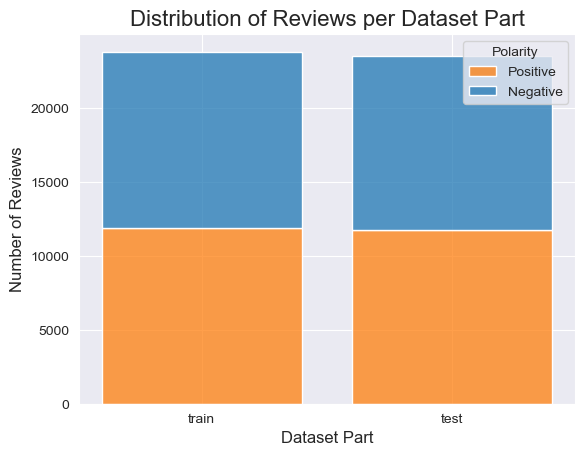

In [22]:
g = sns.histplot(data=df, x='ds_part', hue='pos', multiple='stack', shrink=.8)
plt.xlabel('Dataset Part', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.legend(title='Polarity', loc='upper right', labels=['Positive', 'Negative'])
plt.title('Distribution of Reviews per Dataset Part', fontsize=16)

plt.show()

## 

In [ ]:
def normalize_text(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words_tokenized = word_tokenized(words)
    words_lemmatized = [lemmatizer.lemmatize(word) for word in words_tokenized]
    
    return " ".join(words_lemmatized)